<a href="https://colab.research.google.com/github/marwanthestudent/test_colab/blob/main/_ApplyModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LOAD RHEOMAP + MONGO

In [ ]:
#@title Uploaed Secret
from google.colab import drive
from dotenv import load_dotenv
import os

drive.mount('/content/drive')

#Load secrets
load_dotenv('drive/MyDrive/The Hybrid Atelier/AtelierSummer2025/1 - Slip Summer/6 - Modeling/secrets.env')

MONGO_URI = os.getenv("MONGO_URI")
MONGO_DB = os.getenv("MONGO_DB")

print("Loaded secrets successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded secrets successfully.


In [ ]:
!pip install pymongo
import pymongo
from pymongo import MongoClient
from bson import json_util, ObjectId


# Connect to MongoDB using the URI
client = pymongo.MongoClient(MONGO_URI)

# Access the specified database and collection
db = client[MONGO_DB]

import numpy as np

def extract_features(stack, set="vuong"):
    """
    Extracts a feature vector from a vuong_sv_stack (k x n).

    Parameters:
    - stack: np.ndarray of shape (k, n)
    - set: 'vuong' or 'matnoise' to determine which feature set to extract

    Returns:
    - feature_vector: np.ndarray of shape depending on the set
    """
    if set == "vuong":
        means = np.mean(stack, axis=0)
        features = [means]


    elif set == "matnoise":
        means = np.mean(stack, axis=0)
        stds = np.std(stack, axis=0)
        medians = np.median(stack, axis=0)
        mins = np.min(stack, axis=0)
        maxs = np.max(stack, axis=0)
        ranges = maxs - mins

        # # Strict handling: throw error if mean is zero anywhere
        # if np.any(means == 0):
        #     raise ValueError("the average at a time step is 0")

        # cv = stds / means  # Coefficient of variation

        features = [means, stds, medians, mins, maxs, ranges]

    else:
        raise ValueError(f"Unknown feature set '{set}'. Choose 'vuong' or 'matnoise'.")

    return np.concatenate(features)

In [ ]:
# Step 1: Download the raw file from GitHub
!rm -f rep.py
!wget -q https://raw.githubusercontent.com/The-Hybrid-Atelier/RheoMap/main/dataset/rep.py -O rep.py


import importlib.util
import sys

# Load the module from file
spec = importlib.util.spec_from_file_location("rep", "rep.py")
rep = importlib.util.module_from_spec(spec)
sys.modules["rep"] = rep
spec.loader.exec_module(rep)

# LOAD MODELS

In [26]:
import joblib
import requests
from io import BytesIO

models = {
    "dwell_time": {
        "gray":  "12Fj_ww72uo2NlFPPw0K7IqHW214wiLKD",
        "white": "1Esqpj5WF93ea5CbK9c8pP_0o6E8MBLrT",
        "red":   "1DSKQPwWD5d4JGO1YQX5_U31qvyrMtpA9",
    },
    "profiles": {
        "all":  "1iOkmzEVFonCEsvWEUMghEMj2IQYxjEVn",
    },
    "claybody": {
        "all": "1VZoqEVZhdr4RXSwuxMiN81tmtYBDOvo_"
    },
    "waterloss": {
        "gray": "1Oui0aqwa0lcOj0TrfyEJkHaq2iCw69sw"
    }
}

loaded_models = {}

for task, clay_map in models.items():
    loaded_models[task] = {}
    for clay, file_id in clay_map.items():
        url = f"https://drive.google.com/uc?export=download&id={file_id}"
        response = requests.get(url)
        response.raise_for_status()

        # Use BytesIO + joblib.load
        model_obj = joblib.load(BytesIO(response.content))
        loaded_models[task][clay] = model_obj
        print(f"[✓] Loaded {task} model for {clay}")


[✓] Loaded dwell_time model for gray
[✓] Loaded dwell_time model for white
[✓] Loaded dwell_time model for red
[✓] Loaded profiles model for all
[✓] Loaded claybody model for all
[✓] Loaded waterloss model for gray


In [27]:
# Define mapping
clay_map = {
    "GRAY - EM210": "gray",
    "RED - EM334": "red",
    "B-Mix - 5-2459": "white"
}

# Apply mapping
df_profiles = loaded_models["profiles"]["all"].copy()
df_profiles["clayBody"] = df_profiles["clayBody"].replace(clay_map)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def report_thickness_time(thickness_profile, dwell_model, test, target_thickness):
    # Sort profile to make sure curve is in time order
    prof = thickness_profile.sort_values("time_min")
    t = prof["time_min"].values
    y = prof["master_thickness_mm"].values
    # print(t, y)
    # --- 1. Predicted dwell_time from model ---
    X = np.array(test).reshape(1, -1)[:, dwell_model["keep_idx"]]
    pred = dwell_model["model"].predict(X)[0]

    # --- Step 1: find closest time to pred ---
    idx0 = np.argmin(np.abs(t - pred))
    t0 = t[idx0]
    y0 = y[idx0]
    # print("0", t0, y0)

    # --- Step 2: find when drop >= target_thickness ---
    target_val = target_thickness
    end_idx = None
    for i in range(idx0, len(y)):
        if y[i] - y0 >= target_val:
            end_idx = i
            break

    if end_idx is None:
        raise ValueError("Target thickness not reached in this profile.")

    # --- Step 3: Interpolate crossing ---
    if end_idx > idx0:
        t1, y1 = t[end_idx - 1], y[end_idx - 1]
        t2, y2 = t[end_idx], y[end_idx]

        # how far between y1 and y2 we cross y0+target_thickness
        target_val = y0 + target_thickness
        if y2 != y1:
            frac = (target_val - y1) / (y2 - y1)
            tend = t1 + frac * (t2 - t1)
            yend = y1 + frac * (y2 - y1)
        else:
            tend, yend = t2, y2
    else:
        tend, yend = t[end_idx], y[end_idx]

    delta_time = tend - t0

    # --- Report ---
    print(f"Predicted profile time = {pred:.2f} min")
    print(f"Start time: {t0:.2f} min, thickness={y0:.2f}")
    print(f"End time:   {tend:.2f} min, thickness={yend:.2f}")
    print(f"\n\nRECOMMENDATION \nΔt = {delta_time:.2f} min for thickness={target_thickness} mm")

    # --- Plot ---
    plt.figure(figsize=(5, 3))
    plt.plot(t, y, label="Thickness curve")
    plt.axvline(pred, color="red", linestyle="--", label=f"Pred dwell_time = {pred:.1f} min")
    plt.plot(t0, y0, "go", label="Start thickness")
    plt.plot(tend, yend, "bo", label=f"Target ΔX={target_thickness} mm")
    plt.xlabel("Time (min)")
    plt.ylabel("Thickness (mm)")
    plt.title("Thickness Profile with Predicted Dwell Time")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "pred_dwell_time": pred,
        "start_time": t0,
        "start_thickness": y0,
        "end_time": tend,
        "end_thickness": yend,
        "delta_time": delta_time
    }


# PREDICT

In [ ]:
#MONGO_COLLECTION = "MarblingApplicationfr"
# MONGO_COLLECTION = "ClayIdentifier"
# MONGO_COLLECTION = "Colorful-bowl-fr"
# MONGO_COLLECTION = "ShellThicknessTest"
# MONGO_COLLECTION = "DehydrationTest"
# MONGO_COLLECTION = "mixing"
# MONGO_COLLECTION = "3TimeSample"
MONGO_COLLECTION = "MixingApplicationfr"

In [ ]:
# @title Load REP Measurement (grouped)
import pandas as pd
import numpy as np

# Fetch all REP readings
collection = db[MONGO_COLLECTION]
documents = collection.find({})
df = pd.DataFrame(list(documents))

# Compute base geometric features per REP
df['geom_fv'] = df['data'].apply(rep.extract_features)

# Group by 'name' (assume 3 per group)
vuong_vectors = []
fluctuation_vectors = []
pulses = []
group_info = []

rep_vectors = []
for name, group in df.groupby("name"):
    pulse_stack = np.stack(group['data'].values)
    geom_stack = np.stack(group['geom_fv'].values)  # shape (3, n_features)
    geo_vec = extract_features(geom_stack, "vuong")
    test_vec = extract_features(geom_stack, "matnoise")
    vuong_vectors.append(geo_vec)
    fluctuation_vectors.append(test_vec)
    rep_vectors.append(pulse_stack.mean(0))
    group_info.append(name)
group_info
df_grouped = pd.DataFrame({
    "name": group_info,
    "fluctuation_fv": fluctuation_vectors,
    "geo_fv": vuong_vectors,
    "REP": rep_vectors
})

print(df_grouped.shape)
df_grouped.head()


(46, 4)


,name,fluctuation_fv,geo_fv,REP
0,chaos_0,"[100542.55555555556, 88159.33333333333, 118060...","[100542.55555555556, 88159.33333333333, 118060...","[100542.55555555556, 100544.44444444444, 10054..."
1,chaos_15,"[100510.55555555556, 88023.44444444444, 117939...","[100510.55555555556, 88023.44444444444, 117939...","[100510.55555555556, 100508.88888888889, 10051..."
2,chaos_1_0,"[100430.44444444444, 88127.11111111111, 118338...","[100430.44444444444, 88127.11111111111, 118338...","[100430.44444444444, 100430.44444444444, 10043..."
3,chaos_1_15,"[100351.11111111111, 87973.0, 118037.333333333...","[100351.11111111111, 87973.0, 118037.333333333...","[100351.11111111111, 100352.0, 100345.55555555..."
4,chaos_1_30,"[100372.55555555556, 87800.88888888889, 118464...","[100372.55555555556, 87800.88888888889, 118464...","[100372.55555555556, 100376.33333333333, 10037..."


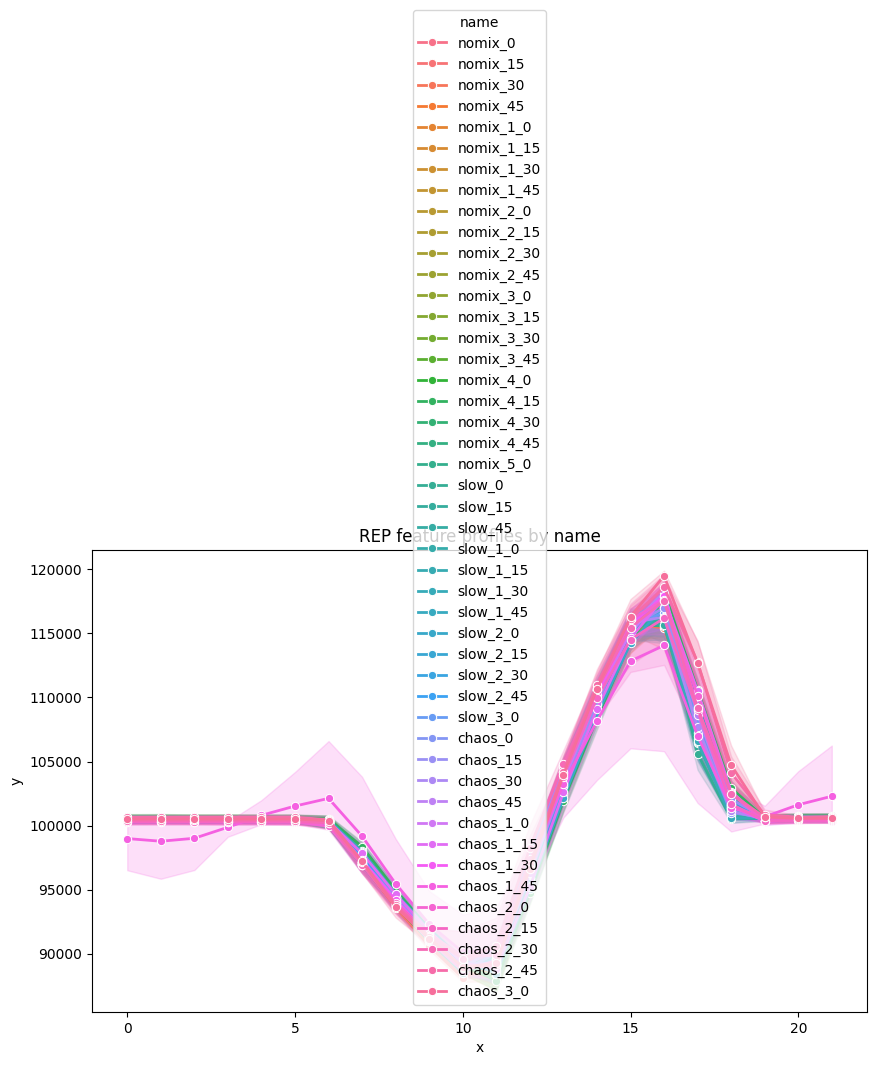

In [ ]:
# @title REP Plot
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# explode REP arrays into long format
long_dfs = []
for idx, row in df.iterrows():
    arr = row["data"]            # 1D array of values
    df_long = pd.DataFrame({
        "x": np.arange(len(arr)),  # index positions
        "y": arr,                  # values
        "name": row["name"]
    })
    long_dfs.append(df_long)

df_long = pd.concat(long_dfs, ignore_index=True)

# Plot with seaborn
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df_long,
    x="x", y="y",
    hue="name",
    marker="o", linewidth=2
)
plt.title("REP feature profiles by name")
plt.show()


In [ ]:
# @title = MarbleOnly
level_map = {
    "terracotta": 0,
    "porcelain_med": 1,
    "porcelain_thickermed": 2,
    "thick_porcelain_frfr": 3
}
label_map = {
    0: "0-terracotta",
    1: "1-porcelain_med",
    2: "2-porcelain_thickermed",
    3: "3-thick_porcelain_frfr"
}

df_grouped["level_num"] = df_grouped["name"].map(level_map)
df_grouped["name"] = df_grouped["level_num"].map(label_map)

order = ["0-terracotta", "1-porcelain_med", "2-porcelain_thickermed", "3-thick_porcelain_frfr"]
df_grouped["name"] = pd.Categorical(df_grouped["name"], categories=order, ordered=True)

df_grouped[["name", "level_num"]].head()


,name,level_num
0,1-porcelain_med,1
1,2-porcelain_thickermed,2
2,0-terracotta,0
3,3-thick_porcelain_frfr,3


In [ ]:
# Assume df_grouped has columns: ["name", "test_vector"]
SAMPLE_MASS = 322
claybody = "gray"
waterloss_model = loaded_models["waterloss"][claybody]

waterloss_masses = {
    "gray": 1000,
}

preds = []
for vec in df_grouped["fluctuation_fv"]:
    # prepare input
    X = np.array(vec).reshape(1, -1)[:, waterloss_model["topk_idx"]]
    # predict
    normalization = SAMPLE_MASS / waterloss_masses[claybody]
    pred = waterloss_model["model"].predict(X)[0] * normalization
    preds.append(pred)

# Add predictions back to DataFrame
df_grouped["pred_waterloss_mL"] = preds

df_grouped = df_grouped.sort_values("name")
df_grouped[["name", "pred_waterloss_mL"]]


,name,pred_waterloss_mL
0,chaos_0,18.335997
1,chaos_15,18.291836
2,chaos_1_0,21.823421
3,chaos_1_15,18.476070
4,chaos_1_30,18.918848
5,chaos_1_45,14.943901
6,chaos_2_0,18.175589
7,chaos_2_15,17.440658
8,chaos_2_30,17.389256
9,chaos_2_45,19.078182


In [ ]:
import numpy as np
np.mean([722, 707, 738])
df.groupby('clayBody').describe()

samples                                     trial            ...  \
              count mean  std  min  25%  50%  75%  max  count      mean  ...   
clayBody                                                                 ...   
RED - EM334   410.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0  410.0  0.997561  ...   
Water           3.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0    3.0  1.000000  ...   

                      samplingPeriod                                     
             75%  max          count mean  std  min  25%  50%  75%  max  
clayBody                                                                 
RED - EM334  2.0  2.0          410.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
Water        1.5  2.0            3.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  

[2 rows x 24 columns]

In [ ]:
# --- Claybody Classification ---
label_map = {
    "B-Mix - 5-2459": "white",
    "GRAY - EM210": "gray",
    "RED - EM334": "red"
}

claybody_classifier = loaded_models["claybody"]["all"]

claybody_preds = []

for vec in df_grouped["fluctuation_fv"]:
    X = np.array(vec).reshape(1, -1)
    cb_pred = claybody_classifier.predict(X)[0]
    cb_mapped = label_map.get(cb_pred, cb_pred)  # short label mapping
    claybody_preds.append(cb_mapped)

print("All classes in model:", claybody_classifier.named_steps["rf"].classes_)
df_grouped["pred_claybody"] = claybody_preds

df_grouped[["name", "pred_claybody"]]

All classes in model: ['B-Mix - 5-2459' 'GRAY - EM210' 'RED - EM334']


,name,pred_claybody
0,1-porcelain_med,gray
1,2-porcelain_thickermed,gray
2,0-terracotta,gray
3,3-thick_porcelain_frfr,gray


In [ ]:
red_test = [99189.0, 87611.33333333333, 114851.66666666667, 99238.66666666667, 10.333333333333334, 15.333333333333334, 19.0, 5.0, 3.6666666666666665, 16.333333333333332, 112042.66666666667, 1.0, 183.48296923692945, 634.0254113379228, 927.1951730293298, 108.96278671587328, 0.4714045207910317, 0.4714045207910317, 0.0, 0.0, 0.4714045207910317, 0.4714045207910317, 2164.371553643741, 0.0, 99294.0, 87950.0, 114316.0, 99286.0, 10.0, 15.0, 19.0, 5.0, 4.0, 16.0, 113015.0, 1.0, 98931.0, 86723.0, 114083.0, 99088.0, 10.0, 15.0, 19.0, 5.0, 3.0, 16.0, 109043.0, 1.0, 99342.0, 88161.0, 116156.0, 99342.0, 11.0, 16.0, 19.0, 5.0, 4.0, 17.0, 114070.0, 1.0, 411.0, 1438.0, 2073.0, 254.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 5027.0, 0.0];

fv_test = np.array([
    red_test
]).reshape(1, -1)

# Predict
y_pred = claybody_classifier.predict(fv_test)
print("Predicted class:", y_pred[0])
print("Model classes:", claybody_classifier.named_steps["rf"].classes_)

Predicted class: RED - EM334
Model classes: ['B-Mix - 5-2459' 'GRAY - EM210' 'RED - EM334']


Predicted profile time = 29.87 min
Start time: 29.49 min, thickness=2.36
End time:   29.49 min, thickness=2.36


RECOMMENDATION 
Δt = 0.00 min for thickness=0 mm


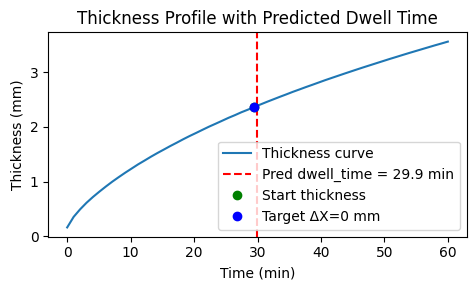

Predicted profile time = 31.47 min
Start time: 31.53 min, thickness=2.46
End time:   31.53 min, thickness=2.46


RECOMMENDATION 
Δt = 0.00 min for thickness=0 mm


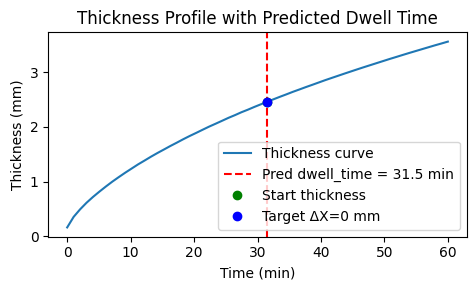

Predicted profile time = 30.99 min
Start time: 30.51 min, thickness=2.41
End time:   30.51 min, thickness=2.41


RECOMMENDATION 
Δt = 0.00 min for thickness=0 mm


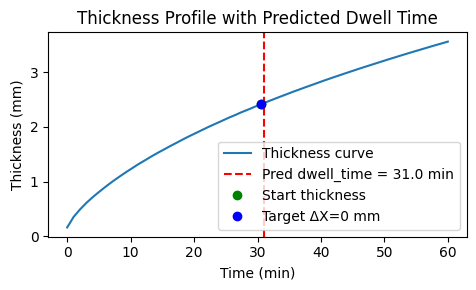

Predicted profile time = 18.48 min
Start time: 18.31 min, thickness=1.77
End time:   18.31 min, thickness=1.77


RECOMMENDATION 
Δt = 0.00 min for thickness=0 mm


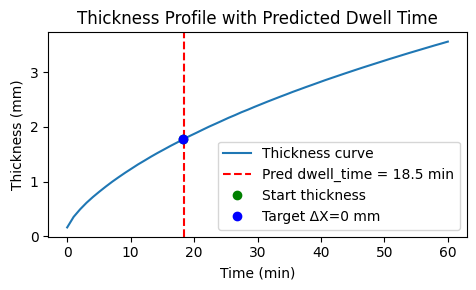

,pred_dwell_time,start_time,start_thickness,end_time,end_thickness,delta_time,name,claybody
0,29.870000,29.491525,2.364581,29.491525,2.364581,0.0,0-terracotta,white
1,31.473333,31.525424,2.459880,31.525424,2.459880,0.0,1-porcelain_med,white
2,30.990000,30.508475,2.412186,30.508475,2.412186,0.0,2-porcelain_thickermed,white
3,18.477778,18.305085,1.774985,18.305085,1.774985,0.0,3-thick_porcelain_frfr,white


In [ ]:
# --- Report Thickness Time for Each Test Vector ---
results = []
force_claybody = "white"
# force_claybody = None

for _, row in df_grouped.iterrows():
    claybody = row["pred_claybody"]   # use predicted claybody
    test_vec = row["fluctuation_fv"]
    if force_claybody is not None:
        claybody = force_claybody

    try:
        res = report_thickness_time(
            thickness_profile=df_profiles[df_profiles["clayBody"] == claybody],
            dwell_model=loaded_models["dwell_time"][claybody],
            test=test_vec,           # feature vector (72,)
            target_thickness=0       # mm drop threshold
        )
        res["name"] = row["name"]
        res["claybody"] = claybody
        results.append(res)
    except Exception as e:
        print(f"⚠️ Skipped {row['name']} ({claybody}): {e}")

# Convert to DataFrame
df_thickness_results = pd.DataFrame(results)

df_thickness_results.head()


In [ ]:
df_thickness_results["closeness_to_reference"] = 100 - (df_thickness_results["start_time"]/60*100)
df_thickness_results[["name", "closeness_to_reference"]]

,name,closeness_to_reference
0,0-terracotta,50.847458
1,1-porcelain_med,47.457627
2,2-porcelain_thickermed,49.152542
3,3-thick_porcelain_frfr,69.491525


In [ ]:
#@title clayBody sanity check

import numpy as np
import pandas as pd

# 1) Which column holds your 72-dim vectors?
FEATURE_COL = "test_vector"   # <- use your 72-dim feature column

# 2) Short label mapping
label_map = {
    "B-Mix - 5-2459": "white",
    "GRAY - EM210":   "gray",
    "RED - EM334":    "red",
}

# 3) Build X from the current df (e.g., 'tera_frfr')
X_list = df_grouped[FEATURE_COL].values
X = np.stack([np.asarray(v).ravel() for v in X_list])  # shape: (n, 72)

# 4) Verify the model expects 72 features
def expected_n_features(model):
    # try plain estimator
    n = getattr(model, "n_features_in_", None)
    if n is not None:
        return n
    # try pipeline inner step (named 'rf' or last step)
    try:
        steps = getattr(model, "named_steps", None)
        if steps:
            # prefer an estimator that exposes n_features_in_
            for name, step in steps.items():
                nf = getattr(step, "n_features_in_", None)
                if nf is not None:
                    return nf
            # fallback: last step
            last = list(steps.values())[-1]
            return getattr(last, "n_features_in_", None)
    except Exception:
        pass
    return None

exp = expected_n_features(claybody_classifier)
print(f"Test vector length = {X.shape[1]} | Model expects = {exp}")
if exp is not None and exp != X.shape[1]:
    raise ValueError(
        f"Feature length mismatch: got {X.shape[1]}, model expects {exp}. "
        f"Reload a classifier trained on 72-dim matnoise, or recompute features to match."
    )

# 5) Predict (use pipeline directly if it's a Pipeline)
raw_preds = claybody_classifier.predict(X)

# 6) Also show confidence, if available
if hasattr(claybody_classifier, "predict_proba"):
    proba = claybody_classifier.predict_proba(X)
    classes = claybody_classifier.classes_
    top_p = proba.max(axis=1)
    top_c = classes[proba.argmax(axis=1)]
else:
    top_p = np.full(len(raw_preds), np.nan)
    top_c = raw_preds

# 7) Map to short labels and print a quick table
out = pd.DataFrame({
    "name": df_grouped.get("name", pd.Series(range(len(raw_preds)))).values,
    "pred_full": raw_preds,
    "pred_short": [label_map.get(p, p) for p in raw_preds],
    "max_prob": top_p
}).sort_values("max_prob", ascending=True, na_position="last")

print(out.head(15).to_string(index=False))

# Optional: majority vote per file
maj_short = out["pred_short"].mode()
print("Majority vote (short):", (maj_short.iloc[0] if not maj_short.empty else "N/A"))

Test vector length = 72 | Model expects = 72
                name    pred_full pred_short  max_prob
thick_porcelain_frfr GRAY - EM210       gray  0.685000
porcelain_thickermed GRAY - EM210       gray  0.826667
       porcelain_med GRAY - EM210       gray  0.866667
          terracotta GRAY - EM210       gray  0.890000
Majority vote (short): gray
